# Import

In [1]:
import pandas
import sklearn
import evaluation
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
GPU_fix = "MemoryFix" # Choose "Disable", "MemoryFix" or "None"

if GPU_fix == "Disable":
    try:
        # Disable all GPUS
        tf.config.set_visible_devices([], 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
elif GPU_fix == "MemoryFix":
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

1 Physical GPUs, 1 Logical GPUs


# Read training data

In [5]:
# https://www.kaggle.com/sionek/ugbc-gs
folder = 'tau_data/'
data = pandas.read_csv(folder + 'training.csv', index_col='id')
#--------------- feature engineering -------------- #
def add_features(df):
    # features used by the others on Kaggle
    df['NEW_FD_SUMP']=df['FlightDistance']/(df['p0_p']+df['p1_p']+df['p2_p'])
    df['NEW5_lt']=df['LifeTime']*(df['p0_IP']+df['p1_IP']+df['p2_IP'])/3
    df['p_track_Chi2Dof_MAX'] = df.loc[:, ['p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof']].max(axis=1)
    #df['flight_dist_sig'] = df['FlightDistance']/df['FlightDistanceError'] # modified to:
    df['flight_dist_sig2'] = (df['FlightDistance']/df['FlightDistanceError'])**2
    # features from phunter
    df['flight_dist_sig'] = df['FlightDistance']/df['FlightDistanceError']
    df['NEW_IP_dira'] = df['IP']*df['dira']
    df['p0p2_ip_ratio']=df['IP']/df['IP_p0p2']
    df['p1p2_ip_ratio']=df['IP']/df['IP_p1p2']
    df['DCA_MAX'] = df.loc[:, ['DOCAone', 'DOCAtwo', 'DOCAthree']].max(axis=1)
    df['iso_bdt_min'] = df.loc[:, ['p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT']].min(axis=1)
    df['iso_min'] = df.loc[:, ['isolationa', 'isolationb', 'isolationc','isolationd', 'isolatione', 'isolationf']].min(axis=1)
    # My:
    # new combined features just to minimize their number;
    # their physical sense doesn't matter
    df['NEW_iso_abc'] = df['isolationa']*df['isolationb']*df['isolationc']
    df['NEW_iso_def'] = df['isolationd']*df['isolatione']*df['isolationf']
    df['NEW_pN_IP'] = df['p0_IP']+df['p1_IP']+df['p2_IP']
    df['NEW_pN_p']  = df['p0_p']+df['p1_p']+df['p2_p']
    df['NEW_IP_pNpN'] = df['IP_p0p2']*df['IP_p1p2']
    df['NEW_pN_IPSig'] = df['p0_IPSig']+df['p1_IPSig']+df['p2_IPSig']
    #My:
    # "super" feature changing the result from 0.988641 to 0.991099
    df['NEW_FD_LT']=df['FlightDistance']/df['LifeTime']
    return df

print("Add features")
train_df = add_features(data)

print("Eliminate features")
filter_out = ['id', 'min_ANNmuon', 'production', 'mass', 'signal',
              'SPDhits','CDF1', 'CDF2', 'CDF3',
              'isolationb', 'isolationc','p0_pt', 'p1_pt', 'p2_pt',
              'p0_p', 'p1_p', 'p2_p', 'p0_eta', 'p1_eta', 'p2_eta',
              'isolationa', 'isolationb', 'isolationc', 'isolationd', 'isolatione', 'isolationf',
              'p0_IsoBDT', 'p1_IsoBDT', 'p2_IsoBDT',
              'p0_IP', 'p1_IP', 'p2_IP',
              'IP_p0p2', 'IP_p1p2',
              'p0_track_Chi2Dof', 'p1_track_Chi2Dof', 'p2_track_Chi2Dof',
              'p0_IPSig', 'p1_IPSig', 'p2_IPSig',
              'DOCAone', 'DOCAtwo', 'DOCAthree']

Add features
Eliminate features


In [7]:
#modified
variables_mod = list(f for f in data.columns if f not in filter_out)
print(len(variables_mod))

28


In [37]:
train_df = data[variables_mod]

In [38]:
msk = np.random.rand(len(train_df)) < 0.8
train = train_df[msk]
val = train_df[~msk]

In [39]:
print('validation samples:',len(val))
print('train samples:',len(train))

validation samples: 13596
train samples: 53956


In [ ]:
plt.figure();
df['DOCAone'].diff().hist(color="k", alpha=0.5, bins=1000);

In [ ]:
train_df['LifeTime'].describe()

# Baseline training

In [40]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(len(variables_mod)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.05)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(200, activation=tf.keras.layers.LeakyReLU(alpha=0.05)), 
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.05)), 
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.05)),  
  tf.keras.layers.Dense(1, activation = tf.keras.activations.sigmoid)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
df_std = train_df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
a = train_df["DOCAone"].to_numpy()
print(a.max())

In [ ]:
train_df[train_df["DOCAone"] > 20]

In [41]:
#Create training arrays
x_train = train.to_numpy()
y_train = data['signal'][msk].to_numpy()
y_train = np.expand_dims(y_train,1)
x_val = val.to_numpy()
y_val = data['signal'][~msk].to_numpy()
y_val = np.expand_dims(y_val,1)

In [42]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=0)

In [45]:
history = model.fit(x_train, y_train, epochs=5, batch_size = 64, validation_data = (x_val,y_val), verbose = 0)

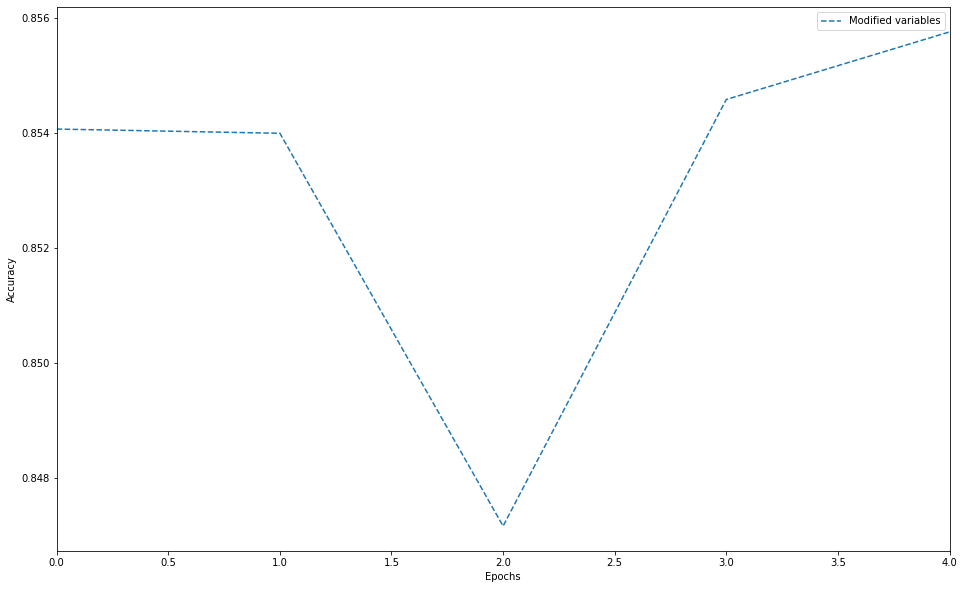

In [46]:
plt.figure(figsize=(16,10))
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
val = plt.plot(history.epoch, history.history['val_'+'accuracy'],
                   '--', label='Modified variables')
#plt.plot(history_mod.epoch, history_mod.history['val_'+'accuracy'], color=val[0].get_color(),
             #label='Modified variables')
plt.legend()
plt.xlim([0,max(history.epoch)])
plt.show()

# Check agreement test

In [47]:
check_agreement = pandas.read_csv(folder + 'check_agreement.csv', index_col='id')
check_agreement = add_features(check_agreement)
agreement_probs = model.predict(check_agreement[variables_mod].to_numpy()).squeeze()
print(agreement_probs)
ks = evaluation.compute_ks(
    agreement_probs[check_agreement['signal'].values == 0],
    agreement_probs[check_agreement['signal'].values == 1],
    check_agreement[check_agreement['signal'] == 0]['weight'].values,
    check_agreement[check_agreement['signal'] == 1]['weight'].values)
print('KS metric', ks, ks < 0.09)

[0.20222375 0.02341378 0.47744298 ... 0.9305945  0.998007   0.9957281 ]
KS metric 0.08048045651076902 True


# Check correlation test

In [48]:
check_correlation = pandas.read_csv(folder + 'check_correlation.csv', index_col='id')
check_correlation = add_features(check_correlation)
correlation_probs = model.predict(check_correlation[variables_mod].to_numpy()).squeeze()
#pd.DataFrame(correlation_probs,
  #                 columns=[variables])
print(correlation_probs)
cvm = evaluation.compute_cvm(correlation_probs, check_correlation['mass'])
print('CvM metric', cvm, cvm < 0.002)

[0.03107161 0.09443697 0.34269217 ... 0.67971605 0.36630565 0.02601336]
CvM metric 0.0010396338097062598 True


# Compute weighted AUC on the training data with min_ANNmuon > 0.4

In [49]:
train_eval = data[data['min_ANNmuon'] > 0.4]
train_probs = model.predict(train_eval[variables_mod].to_numpy()).squeeze()
AUC = sklearn.metrics.roc_auc_score(train_eval['signal'], train_probs)
print('AUC', AUC)

AUC 0.9202100153996597


# Predict test, create file for kaggle

In [42]:
result = pandas.DataFrame({'id': test.index})
result['prediction'] = model.predict(test[variables].to_numpy()).squeeze()

In [43]:
result.to_csv('submission.csv', index=False, sep=',')

In [ ]:
!ls -l submission.csv

In [ ]:
result.to_csv?